## Credit card fraud detection (+resampling via imblearn)

### Data preprocessing

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('creditcard.csv')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [27]:
df.isnull().values.any()

False

In [28]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [29]:
non_fraud = len(df[df.Class == 0])
fraud = len(df[df.Class == 1])

print('Number of Genuine transactions: ', non_fraud)
print('Number of Fraud transactions: ', fraud)
print('Percentage of Fraud transactions: {:.4f}'.format((fraud / (fraud + non_fraud)) * 100))

Number of Genuine transactions:  284315
Number of Fraud transactions:  492
Percentage of Fraud transactions: 0.1727


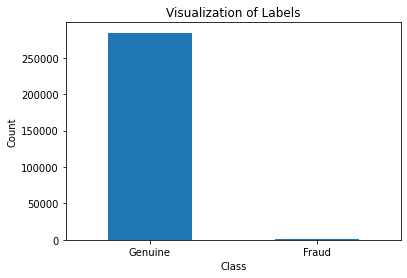

In [30]:
labels = ['Genuine', 'Fraud']
count_classes = df.value_counts(df['Class'], sort= True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('Visualization of Labels')
plt.ylabel('Count')
plt.xticks(range(2), labels)
plt.show()

In [31]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['NormalizedAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Amount', 'Time'], inplace= True, axis= 1)
target = df['Class']
data = df.drop(['Class'], axis= 1)

In [32]:
from sklearn.model_selection import train_test_split

data_train, data_valid, target_train, target_valid = train_test_split(data, target, test_size= 0.3, random_state=0)

print('Shape of data_train: ', data_train.shape)
print('Shape of data_valid: ', data_valid.shape)

Shape of data_train:  (199364, 29)
Shape of data_valid:  (85443, 29)


### Modeling

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


dt_base = DecisionTreeClassifier()
rfc_base = RandomForestClassifier(n_estimators=100)

In [34]:
dt_model = dt_base.fit(data_train, target_train)
dt_pred = dt_model.predict(data_valid)
dt_score = dt_model.score(data_valid, target_valid)

rfc_model = rfc_base.fit(data_train, target_train)
rfc_pred = rfc_model.predict(data_valid)
rfc_score = rfc_model.score(data_valid, target_valid)

print('Decision Tree Score: ', dt_score)
print('Random Forest Score: ', rfc_score)

Decision Tree Score:  0.999204147794436
Random Forest Score:  0.9994616293903538


Metrics output function:

In [35]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def metrics(actuals, predictions):
    print('Accuracy: {:.5f}'.format(accuracy_score(actuals, predictions)))
    print('Precision: {:.5f}'.format(precision_score(actuals, predictions)))
    print('Recall: {:.5f}'.format(recall_score(actuals, predictions)))
    print('F1-score: {:.5f}'.format(f1_score(actuals, predictions)))

Confusion Matrix - Decision Tree
[[85265    31]
 [   37   110]] 



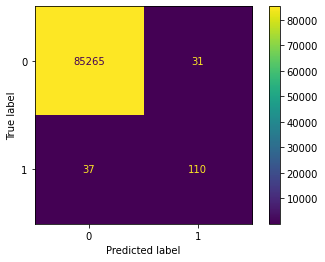

In [36]:
dt_cm = confusion_matrix(target_valid, dt_pred.round())
print('Confusion Matrix - Decision Tree')
print(dt_cm, '\n')

cm_disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm)
cm_disp.plot();

In [37]:
print('Evaluation of Decision Tree model \n')
metrics(target_valid, dt_pred.round())

Evaluation of Decision Tree model 

Accuracy: 0.99920
Precision: 0.78014
Recall: 0.74830
F1-score: 0.76389


Confusion Matrix - Random Forest
[[85288     8]
 [   38   109]] 



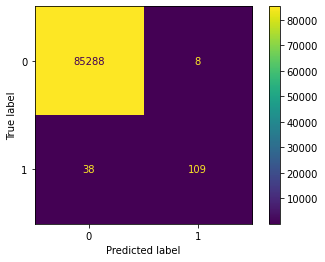

In [38]:
rfc_cm = confusion_matrix(target_valid, rfc_pred.round())
print('Confusion Matrix - Random Forest')
print(rfc_cm, '\n')

cm_disp = ConfusionMatrixDisplay(confusion_matrix=rfc_cm)
cm_disp.plot();

In [39]:
print('Evaluation of Random Forest model \n')
metrics(target_valid, rfc_pred.round())

Evaluation of Random Forest model 

Accuracy: 0.99946
Precision: 0.93162
Recall: 0.74150
F1-score: 0.82576


Since dataset is imbalansed, it is needed to do something about it

## Dealing with imbalance

In [40]:
from collections import Counter
from imblearn.over_sampling import SMOTE

X_resampled, Y_resampled = SMOTE().fit_resample(data, target)
print('Resampled shape of X: ', X_resampled.shape)
print('Resampled shape of Y: ', Y_resampled.shape)
value_counts = Counter(Y_resampled)

print(value_counts)
train_X, test_X, train_Y, test_Y = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=0)

Resampled shape of X:  (568630, 29)
Resampled shape of Y:  (568630,)
Counter({0: 284315, 1: 284315})


In [41]:
rfc_resampled_model = rfc_base.fit(data_train, target_train)
rfc_pred_resampled = rfc_resampled_model.predict(data_valid)
rfc_score_resampled = rfc_resampled_model.score(data_valid, target_valid)

print('Resampled data Random Forest Score: ', rfc_score_resampled)

Resampled data Random Forest Score:  0.9995201479348805


Confusion Matrix - Random Forest after Resampling
[[85289     7]
 [   34   113]] 



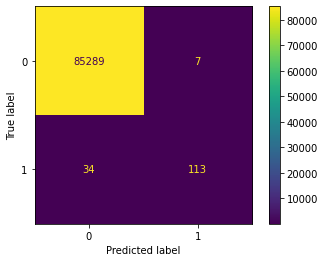

In [42]:
rfc_cm_resampled = confusion_matrix(target_valid, rfc_pred_resampled.round())
print('Confusion Matrix - Random Forest after Resampling')
print(rfc_cm_resampled, '\n')

cm_disp = ConfusionMatrixDisplay(confusion_matrix=rfc_cm_resampled)
cm_disp.plot();

In [43]:
print('Evaluation of Random Forest Model after Resampling')
print()
metrics(target_valid, rfc_pred_resampled.round())

Evaluation of Random Forest Model after Resampling

Accuracy: 0.99952
Precision: 0.94167
Recall: 0.76871
F1-score: 0.84644


Скор немного поднялся (ожидалось больше)